In [11]:
%pip install -r requirements.txt

  Using cached Pyro-3.16.tar.gz (298 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [22 lines of output]
      Traceback (most recent call last):
        File "/Users/asmit/Documents/Fall24_Classes/SDS336/Austin_Trees/Trees/lib/python3.11/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
          main()
        File "/Users/asmit/Documents/Fall24_Classes/SDS336/Austin_Trees/Trees/lib/python3.11/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/Users/asmit/Documents/Fall24_Classes/SDS336/Austin_Trees/Trees/lib/python3.11/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", l

# Modeling

## Import data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from pytorch_tcn import TCN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from datetime import datetime

In [2]:
url = "https://raw.githubusercontent.com/AsmitC/Austin_Trees/refs/heads/victournguyen/purpleair-pull-data/cleaned_data.csv"
df = pd.read_csv(url)
print(f'Shape: {df.shape}')
df.head()

Shape: (121625, 25)


,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,...,other,total_diameter,canopy_coverage_percentage,PRCP,year_month,cluster,season_Fall,season_Spring,season_Summer,season_Winter
0,2024-10-24 18:00:00+00:00,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
1,2024-10-24 06:00:00+00:00,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
2,2024-10-24 00:00:00+00:00,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
3,2024-10-23 00:00:00+00:00,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False
4,2024-10-23 18:00:00+00:00,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,True,False,False,False


In [3]:
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})
df.head()

,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,...,other,total_diameter,canopy_coverage_percentage,PRCP,year_month,cluster,season_Fall,season_Spring,season_Summer,season_Winter
0,2024-10-24 18:00:00+00:00,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
1,2024-10-24 06:00:00+00:00,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
2,2024-10-24 00:00:00+00:00,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
3,2024-10-23 00:00:00+00:00,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0
4,2024-10-23 18:00:00+00:00,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,...,130,22595.5,66.596351,0.0,2024-10,0,1,0,0,0


## Preprocessing

In [4]:
# Extract time features
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df['hour'] = df['time_stamp'].dt.hour
df['day_of_week'] = df['time_stamp'].dt.dayofweek
df['month'] = df['time_stamp'].dt.month
df.head()

,time_stamp,humidity,temperature,pressure,pm2.5_alt,pm2.5_atm,sensor_index,latitude,longitude,altitude,...,PRCP,year_month,cluster,season_Fall,season_Spring,season_Summer,season_Winter,hour,day_of_week,month
0,2024-10-24 18:00:00+00:00,35.447,92.044,981.676,2.5,3.2195,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,18,3,10
1,2024-10-24 06:00:00+00:00,61.950,78.405,984.603,3.6,5.6470,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,6,3,10
2,2024-10-24 00:00:00+00:00,45.133,83.672,985.485,3.1,4.7600,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,0,3,10
3,2024-10-23 00:00:00+00:00,48.216,83.123,986.001,2.6,3.9515,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,0,2,10
4,2024-10-23 18:00:00+00:00,33.578,93.095,985.318,2.5,3.2565,2862,30.366156,-97.76529,899.0,...,0.0,2024-10,0,1,0,0,0,18,2,10


In [5]:
df.columns

Index(['time_stamp', 'humidity', 'temperature', 'pressure', 'pm2.5_alt',
       'pm2.5_atm', 'sensor_index', 'latitude', 'longitude', 'altitude', 'Oak',
       'Elm', 'Pecan', 'Crape Myrtle', 'Ashe Juniper', 'other',
       'total_diameter', 'canopy_coverage_percentage', 'PRCP', 'year_month',
       'cluster', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'hour', 'day_of_week', 'month'],
      dtype='object')

In [6]:
# Define features and target
features = ['humidity', 'temperature', 'pressure','altitude', 'Oak',
       'Elm', 'Pecan', 'Crape Myrtle', 'Ashe Juniper', 'other',
       'total_diameter', 'season_Fall', 'season_Spring', 'season_Summer',
       'season_Winter', 'latitude', 'longitude', 'canopy_coverage_percentage',
       'PRCP', 'hour', 'day_of_week', 'month']
target = 'pm2.5_alt'

# Drop NA values
before_drop = df.shape[0]
df = df.dropna(subset=features+[target])
after_drop = df.shape[0]
print(f'Lost {(before_drop-after_drop)/before_drop*100:0.2f}% of data by removing NA')

Lost 1.61% of data by removing NA


In [7]:
X = df[features]
y = df[target]

# Split df into training, val, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Old:

RF

rf = RandomForestRegressor(
    n_estimators=190,         # Number of trees in the forest
    max_depth=15,             # Maximum depth of each tree
    min_samples_split=3,      # Minimum samples required to split a node
    min_samples_leaf=3,       # Minimum samples required at a leaf node
    random_state=42           # Ensures reproducibility
)

Best score: 23.469028992220643

XGBoost
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 600, 'subsample': 0.9}
Best mse: 22.214858875924424

TCN
num_channels = [16, 32, 64, 128]  # Number of filters in each layer
kernel_size = 5
dropout = 0.3
model = HybridTCN(input_size, output_size, num_channels, kernel_size, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

KNN
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'}
Best KNN Test MSE: 29.4558

# Random Forest

In [8]:
# param_grid = {
#     'n_estimators': [_ for _ in range(150, 251, 25)],
#     'max_depth': [_ for _ in range(10, 21)],
#     'min_samples_split': [_ for _ in range(2, 5)],
#     'min_samples_leaf': [_ for _ in range(2, 5)]
# }
# 
# # min_samples_split=3, min_samples_leaf=3, n_estimators=190
# grid = GridSearchCV(RandomForestRegressor(), param_grid=param_grid,
#                     n_jobs=-1, scoring='neg_mean_squared_error')
# grid.fit(X_train, y_train)
# 
# # Print best parameters and score from grid search
# print("Best parameters:", grid.best_params_)
# print("Best mse:", -grid.best_score_)
# 
# # Get the best estimator
# rf = grid.best_estimator_

In [9]:
rf_regressor = RandomForestRegressor(
    n_estimators=250,         # Number of trees in the forest
    max_depth=20,           # Maximum depth of each tree
    min_samples_split=4,      # Minimum samples required to split a node
    min_samples_leaf=2,       # Minimum samples required at a leaf node
    random_state=42           # Ensures reproducibility
)

# Step 2: Fit the model
rf_regressor.fit(X_train, y_train)

# Step 3: Make predictions
y_pred = rf_regressor.predict(X_test)


# Step 4: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 16.134905371515597
R^2 Score: 0.6184841865664898


# XGBoost

In [10]:
# # Define the parameter grid for XGBoost
# param_grid = {
#     'max_depth': [10, 11, 12], # 10
#     'learning_rate': [0.01, 0.02, 0.03], # 0.02
#     'n_estimators': [600, 700], # 600
#     'subsample': [0.8, 0.85, 0.9], # 0.9
#     'colsample_bytree': [0.8, 0.85, 0.9] # 0.8
# }
# 
# # Initialize the XGBoost regressor
# xgb_ = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
# 
# # CV
# grid = GridSearchCV(estimator=xgb_, param_grid=param_grid, 
#                     scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=1)
# 
# grid.fit(X_train, y_train)
# 
# # Display results
# print("Best parameters:", grid.best_params_)
# print("Best mse:", -grid.best_score_)

In [11]:
# Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 600, 'subsample': 0.9}
best_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.8,
    learning_rate=0.02,
    max_depth=10,
    n_estimators=600,
    subsample=0.9,
    random_state=42
)
best_xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Mean Squared Error: {mse_xgb}")
print(f"R^2 Score: {r2_xgb}")

Mean Squared Error: 13.980673479128617
R^2 Score: 0.6694217975300694


# Neural Network

In [12]:
# # Scale the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# 
# # Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(2)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(2)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
# 
# # Create DataLoader
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [13]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# 
# # ----------------------------
# # Attention Layer
# # ----------------------------
# class AttentionLayer(nn.Module):
#     def __init__(self, input_dim):
#         super(AttentionLayer, self).__init__()
#         self.attention_weights = nn.Parameter(torch.randn(input_dim))
# 
#     def forward(self, x):
#         # x shape: (batch_size, num_channels, sequence_length)
#         attention_scores = torch.matmul(x.transpose(1, 2), self.attention_weights)
#         attention_scores = torch.softmax(attention_scores, dim=-1)  # Normalize attention scores
#         weighted_output = torch.matmul(x, attention_scores.unsqueeze(-1)).squeeze(-1)
#         return weighted_output
# 
# # ----------------------------
# # Temporal Convolutional Network (TCN) with Attention
# # ----------------------------
# class HybridTCN(nn.Module):
#     def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
#         super(HybridTCN, self).__init__()
#         self.tcn = TCN(input_size, num_channels[-1], num_channels, kernel_size, dropout)
#         self.attention = AttentionLayer(num_channels[-1])
#         self.fc = nn.Linear(num_channels[-1], output_size)
# 
#     def forward(self, x):
#         # Input shape: (batch_size, num_channels, sequence_length)
#         tcn_out = self.tcn.network(x)  # Output of TCN
#         attended_out = self.attention(tcn_out)  # Attention over TCN outputs
#         output = self.fc(attended_out)  # Final fully connected layer
#         return output
# 
# # ----------------------------
# # Initialize Hybrid TCN + Attention
# # ----------------------------
# # Initialize the model, loss function, and optimizer
# input_size = X_train.shape[1]  # Number of input features
# output_size = 1  # Predicting PM2.5
# num_channels = [16, 32, 64, 128]  # Number of filters in each layer
# kernel_size = 5
# dropout = 0.3
# model = HybridTCN(input_size, output_size, num_channels, kernel_size, dropout)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# 
# # ----------------------------
# # Training the Model
# # ----------------------------
# epochs = 100
# train_loss = []
# test_losses = []
# stop_indicator = 0
# 
# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     for batch_inputs, batch_targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
#         optimizer.zero_grad()
#         outputs = model(batch_inputs)
#         loss = criterion(outputs, batch_targets.view(-1, 1))
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
# 
#     avg_loss = total_loss / len(train_loader)
#     train_loss.append(avg_loss)
#     print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.4f}")
# 
#     # ----------------------------
#     # Evaluating the Model
#     # ----------------------------
#     model.eval()
#     with torch.no_grad():
#         test_loss = 0
#         for batch_inputs, batch_targets in test_loader:
#             outputs = model(batch_inputs)
#             loss = criterion(outputs, batch_targets.view(-1, 1))
#             test_loss += loss.item()
# 
#         avg_test_loss = test_loss / len(test_loader)
#         test_losses.append(avg_test_loss)
#         print(f"Test Loss: {avg_test_loss:.4f}")
# 
#         # Early stopping logic
#         if epoch >= 10 and avg_test_loss > min(test_losses):
#             stop_indicator += 1
#         else:
#             stop_indicator = 0
# 
#         if stop_indicator >= 10:
#             print("Model plateaued. Stopping early.")
#             break
# 
# # ----------------------------
# # Plot Train vs Test Loss
# # ----------------------------
# plt.figure()
# plt.plot(range(len(train_loss)), train_loss, label='Train Loss')
# plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
# plt.title("Train vs Test Loss")
# plt.xlabel("Epochs")
# plt.ylabel("MSE")
# plt.legend()
# plt.tight_layout()
# plt.show()

# KNN

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'n_neighbors': range(1, 20),  # Number of neighbors to consider
#     'weights': ['uniform', 'distance'],  # Uniform weights or distance-based
#     'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
# }
# 
# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=KNeighborsRegressor(),
#     param_grid=param_grid,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     verbose=1,
#     n_jobs=-1
# )
# 
# # Fit GridSearchCV to the training data
# grid_search.fit(X_train_scaled, y_train)
# 
# # Get the best model and its parameters
# best_knn = grid_search.best_estimator_
# best_params = grid_search.best_params_
# print(f"Best Parameters: {best_params}")

In [16]:
best_knn = KNeighborsRegressor(
    metric='manhattan',
    n_neighbors=18,
    weights='distance'
)
best_knn.fit(X_train_scaled, y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=18, weights='distance')

Best KNN Test MSE: 25.1837


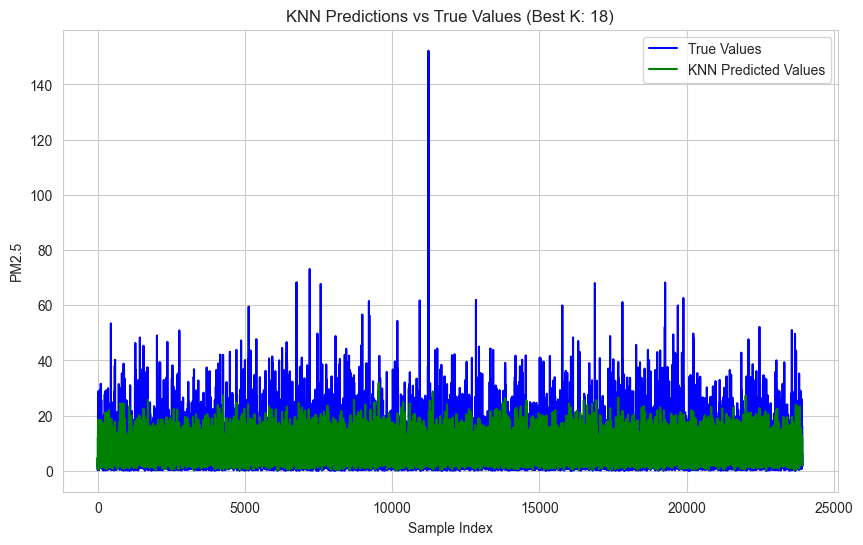

In [17]:
# Predict on the test set using the best KNN model
y_pred_knn = best_knn.predict(X_test_scaled)

# Calculate the MSE for the best KNN model
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"Best KNN Test MSE: {mse_knn:.4f}")

# Plot the true values vs the KNN predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.to_numpy(), label="True Values", color="blue")
plt.plot(y_pred_knn, label="KNN Predicted Values", color="green")
plt.legend()
plt.title(f"KNN Predictions vs True Values (Best K: 18)")
plt.xlabel("Sample Index")
plt.ylabel("PM2.5")
plt.show()

# Interpretability

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay
import shap

models = [
    ('Random Forest', rf_regressor),
    ('XGBoost', best_xgb),
    # ('tcn', model),
    ('KNN', best_knn)
]

## Residual Plot

In [19]:
shap_data_pts = X_train.sample(n=100, random_state=42)

for n, m in models:
    n_ = n.replace(' ', '')
    
    # Residual plot
    y_pred = m.predict(X_test)
    residuals = y_test - y_pred
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted PM2.5")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {n}")
    plt.savefig(f'./plots/residual_plot_{n_}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # PDP
    tree_types = ['Oak', 'Elm', 'Pecan', 'Crape Myrtle', 'Ashe Juniper', 'other']
    for ft in tree_types:
        PartialDependenceDisplay.from_estimator(rf_regressor, X, [ft], kind='average')
        plt.title(f'PDP for Number of {ft} Trees')
        ft_ = ft.replace(' ', '')
        plt.savefig(f'./plots/pdp_{ft_}_{n_}.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    # SHAP
    explainer = shap.Explainer(m)
    shap_values = explainer(shap_data_pts)
    shap.plots.waterfall(shap_values[2], show=False)
    plt.title(f'Example Shapley Value Waterfall Plot for {n}')
    plt.savefig(f'./plots/shap_waterfall_{n_}.png', dpi=300, bbox_inches='tight')
    plt.close()

    shap.plots.beeswarm(shap_values, show=False)
    plt.title(f'Shapley Value Beeswarm Plot for {n}')
    plt.savefig(f'./plots/shap_beeswarm_{n_}.png', dpi=300, bbox_inches='tight')
    plt.close()

C:\Users\Victor Nguyen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsRegressor(metric='manhattan', n_neighbors=18, weights='distance')